In [16]:
import torch_geometric
from torch_geometric.datasets import MD17
from torch_geometric.nn import GCNConv
from torch.nn import Module, Embedding, Linear, MSELoss, LeakyReLU
from torch.optim import Adam
from torch_geometric.nn import global_mean_pool
import torch
import matplotlib.pyplot as plt
from torch import Tensor

In [17]:
# load in dataset
dataset = MD17(root='../data/benzene', name='benzene', transform=None, pre_transform=None)

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch_geometric/data/dataset.py:239: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


In [132]:
class ToyGCN(Module):
    def __init__(self):
        super().__init__()
        
        # initialize layers
        self.embedding = Embedding(118, 16)
        self.conv1 = GCNConv(16, 16)
        self.lin1 = Linear(16, 16)
        self.conv2 = GCNConv(16, 16)
        self.lin2 = Linear(16, 4)
        self.lin3 = Linear(4, 1)
        self.non_linearity = LeakyReLU()

    # define forward pass
    def forward(self, data):
        # get relevant parts from data arg
        edge_index = data.edge_index        
        pos = data.pos
        pos.requires_grad = True
        
        # create edge_attr as the distance between two connected nodes
        edge_attr = []
        for src, tar in zip(edge_index[0], edge_index[1]):
            dist = torch.dist(pos[src.item()], pos[tar.item()])
            edge_attr.append(dist)
        edge_attr = torch.stack(edge_attr)
        
        # initialize E_hat
        E_hat = data.z

        # embed E_hat and put it through embedding, conv, linear layers
        E_hat = self.embedding(E_hat)
        
        E_hat = self.conv1(E_hat, edge_index, edge_attr)
        E_hat = self.non_linearity(E_hat)
        
        E_hat = self.lin1(E_hat)
        E_hat = self.non_linearity(E_hat)
        
        E_hat = self.conv2(E_hat, edge_index, edge_attr)
        E_hat = self.non_linearity(E_hat)
        
        E_hat = self.lin2(E_hat)
        E_hat = self.non_linearity(E_hat)
        
        E_hat = self.lin3(E_hat)
        E_hat = self.non_linearity(E_hat)
        
        # combine representations of all nodes
        # into single graph-level prediction
        E_hat = global_mean_pool(E_hat, data.batch)
        E_hat = E_hat.sum()
        
        # calculate the force on each atom, which is the negative gradient of the atom's position
        E_hat.backward(retain_graph=True)
        F_hat = pos.grad * -1
        
        return E_hat, F_hat

In [197]:
model = ToyGCN()
model.train()

loss_fn = MSELoss()
optimizer = Adam(model.parameters(), 0.0001)

In [198]:
mini_dataset = dataset[:100]
data = mini_dataset[0]

In [208]:
losses = []

for _ in range(1000):
    for data in mini_dataset[:1]:        
        E = data.energy
        F = data.force
        E_hat, F_hat = model(data)
        
        F_hat.requires_grad = True
        
        optimizer.zero_grad()

        E_loss = loss_fn(E_hat, E)
        F_error = F_hat - F
        F_squared_error = torch.square(F_error)
        F_atomwise_error_magnitudes = torch.sum(F_squared_error, dim=1)
        F_loss = torch.div(torch.sum(F_squared_error), F.size()[0])
        
        # loss = F_loss * 10
        loss = E_loss
        
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()

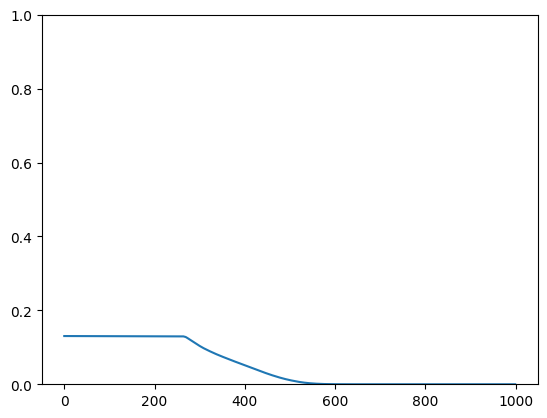

In [209]:
plt.plot(range(len(losses)), losses)
plt.ylim([0, 1])  # Set the maximum y-axis value
plt.show()

In [214]:
torch.max(F)

tensor(1.4861e-05)